In [158]:
import os

from datetime import datetime
import pandas as pd

import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 1000)

In [105]:
directory_path = "/Users/ryangeygan/Downloads/nicole_cases/"

In [135]:
def get_counts(target, source):
    for i, w in enumerate(source):
        if w == target:
            return [source[i+1], source[i+2], source[i+3], source[i+4]]
    return None

def get_relief_doctors(target, source):
    doctors = []
    for i, w in enumerate(source):
        if w == target:
            doctors.append(source[i+1])
    return doctors

def find_all_relief_doctors(directory_path, target_word):
    all_doctors = []
    # Iterate over all files in the directory
    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)
        # Read the content of the file
        with open(file_path, "r") as file:
            text = file.read()
            # Split the text into words
            words = text.split()
            # Find doctors related to the target word
            doctors = get_relief_doctors(target_word, words)
            # Add doctors to the list of all doctors
            all_doctors.extend(doctors)
    # Return unique doctors
    return list(set(all_doctors))

In [108]:
fte_doctors = ['Kuha', 'Elden', 'Blumenthal', 'Rabines', 'Pearson']

In [109]:
all_relief_doctors = find_all_relief_doctors(directory_path, 'Dr.')

In [110]:
all_doctors = fte_doctors + all_relief_doctors

In [140]:
# Create an empty DataFrame to store the data
df_data = []

# Iterate over all files in the directory
for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    # Extract date from the filename
    year = filename.split('.')[0]
    month = filename.split('.')[1]
    # Format the date as "Month Year"
    date = datetime(int(year), int(month), 1)
    formatted_date = date.strftime("%B %Y")
    # Read the content of the file
    with open(file_path, "r") as file:
        text = file.read()
        # Split the text into words
        words = text.split()
        # Iterate over all doctors
        for doctor in all_doctors:
            # Get counts for the doctor
            counts = get_counts(doctor, words)
            if counts is not None:
                total_production = float(counts[0])
                case_count = int(counts[1])
                average = float(counts[2])
                percent_total = float(counts[3].strip('%')) / 100
                # Append data to the DataFrame
                df_data.append([formatted_date, doctor, total_production, case_count, average, percent_total])

# Create a DataFrame from the collected data
df = pd.DataFrame(df_data, columns=["date", "doctor", "total_production", "case_count", "average", "percent_total"])

df['date'] = pd.to_datetime(df.date)

/var/folders/wq/8mxmhthx1qjg6pq5jr3045k40000gn/T/ipykernel_27668/136966020.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df.date)


In [152]:
df.doctor.unique()

array(['Kuha', 'Elden', 'Blumenthal', 'MJC', 'ACM', 'VP', 'MAS', 'MER',
       'ALS', 'KBV', 'BG', 'KPR', 'ACO', 'AMB', 'RE', 'Rabines',
       'Pearson', 'DLG', 'SL', 'LSO', 'MLK', 'KN', 'LWS', 'LS', 'LSV',
       'AFV', 'BGV', 'AS.'], dtype=object)

In [154]:
plt_df = df

acronym_mapping = {
    'MJC': 'Relief',
    'ACM': 'Relief',
    'VP': 'Relief',
    'MAS': 'Relief',
    'MER': 'Relief',
    'ALS': 'Relief',
    'KBV': 'Relief',
    'BG': 'Relief',
    'KPR': 'Relief',
    'ACO': 'Relief',
    'AMB': 'Relief',
    'RE': 'Relief',
    'DLG': 'Relief',
    'SL': 'Relief',
    'LSO': 'Relief',
    'MLK': 'Relief',
    'KN': 'Relief',
    'LWS': 'Relief',
    'LS': 'Relief',
    'LSV': 'Relief',
    'AFV': 'Relief',
    'BGV': 'Relief',
    'AS.': 'Relief'
}

# Replace acronyms with 'Relief' using the mapping dictionary
plt_df['doctor'] = plt_df['doctor'].replace(acronym_mapping)

In [157]:
plt_df.head()

,date,doctor,total_production,case_count,average,percent_total
0,2022-09-01,Kuha,37964.53,86,441.44,0.16
1,2022-09-01,Elden,21776.22,40,544.40,0.09
2,2022-09-01,Blumenthal,6922.78,23,300.99,0.03
3,2022-09-01,Relief,11288.82,46,245.40,0.05
4,2022-09-01,Relief,60855.20,171,355.87,0.25


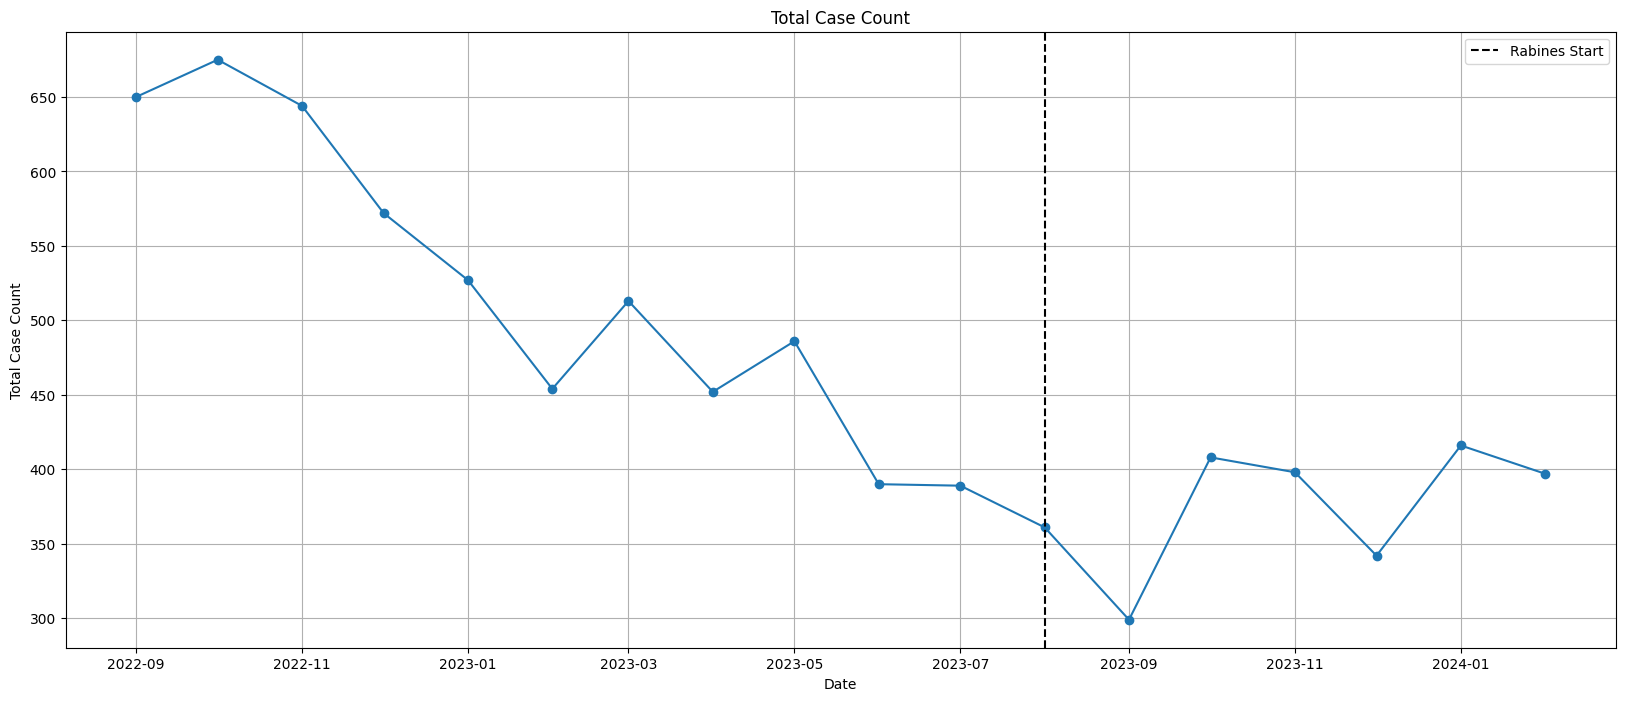

In [184]:
plt.rcParams['figure.figsize'] = [20, 8]

total_case_count = plt_df.groupby('date')['case_count'].sum().reset_index()

# Plot the total case count over time
plt.plot(total_case_count['date'], total_case_count['case_count'], marker='o')

# Add a vertical dotted black line at August 2023
plt.axvline(pd.to_datetime('August 2023'), color='black', linestyle='--', label='Rabines Start')

plt.xlabel('Date')
plt.ylabel('Total Case Count')
plt.title('Total Case Count')
plt.legend()
plt.grid(True)
plt.show()

In [190]:
df = total_case_count

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [196]:
from statsmodels.tsa.seasonal import seasonal_decompose

results = seasonal_decompose(df, period = 12)

results.plot(results)

ValueError: x must have 2 complete cycles requires 24 observations. x only has 18 observation(s)

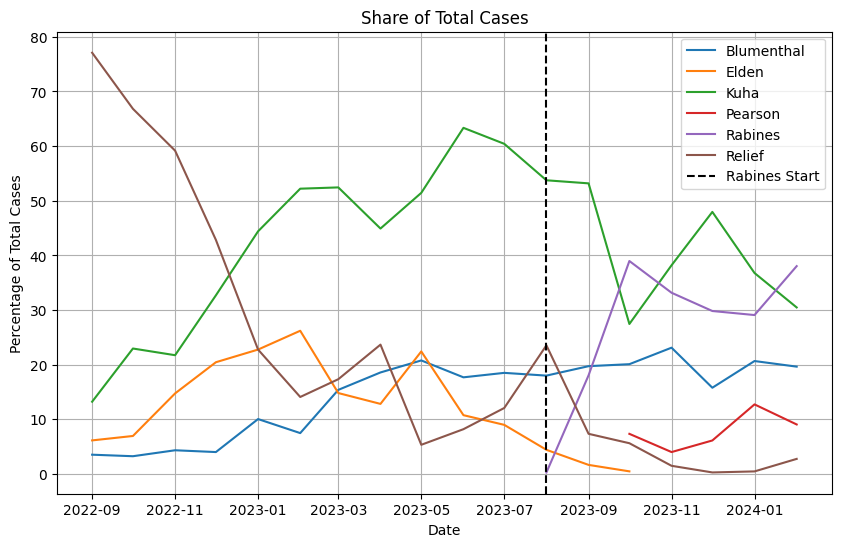

In [182]:
# Group by date and doctor, and sum the case count
total_cases_by_doctor = plt_df.groupby(['date', 'doctor'])['case_count'].sum().reset_index()

# Calculate the total cases for each date
total_cases_by_date = total_cases_by_doctor.groupby('date')['case_count'].sum().reset_index()

# Merge the total cases for each date with the total cases by doctor
merged_df = pd.merge(total_cases_by_doctor, total_cases_by_date, on='date', suffixes=('', '_total'))

# Calculate the percentage of total cases for each doctor at each date
merged_df['percentage'] = (merged_df['case_count'] / merged_df['case_count_total']) * 100

# Pivot the DataFrame to have doctors as columns
pivot_df = merged_df.pivot(index='date', columns='doctor', values='percentage')

# Plot the percentage of total cases for each doctor over time
plt.figure(figsize=(10, 6))
for column in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[column], label=column)

# Add a vertical dotted black line at August 2023
plt.axvline(pd.to_datetime('August 2023'), color='black', linestyle='--', label='Rabines Start')

plt.xlabel('Date')
plt.ylabel('Percentage of Total Cases')
plt.title('Share of Total Cases')
plt.legend()
plt.grid(True)
plt.show()

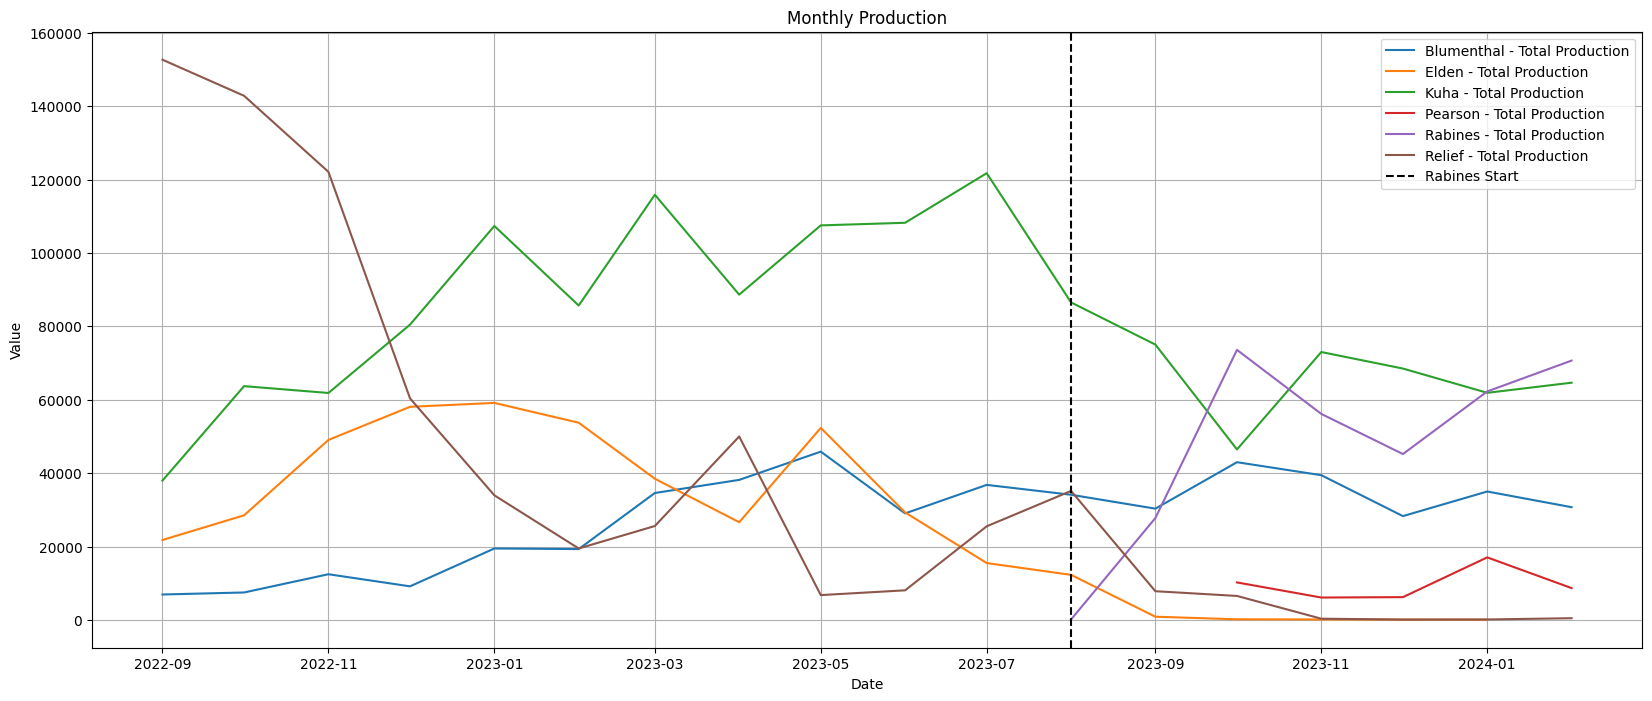

In [181]:
plt.rcParams['figure.figsize'] = [20, 8]

# Group by doctor and date, and compute sums
grouped_df = plt_df.groupby(['doctor', 'date']).sum().reset_index()

for doctor in grouped_df['doctor'].unique():
    df_doctor = grouped_df[grouped_df['doctor'] == doctor]
    plt.plot(df_doctor['date'], df_doctor['total_production'], label=f'{doctor} - Total Production')

# Add a vertical dotted black line at August 2023
plt.axvline(pd.to_datetime('August 2023'), color='black', linestyle='--', label='Rabines Start')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Monthly Production')
plt.legend()
plt.grid(True)
plt.show()

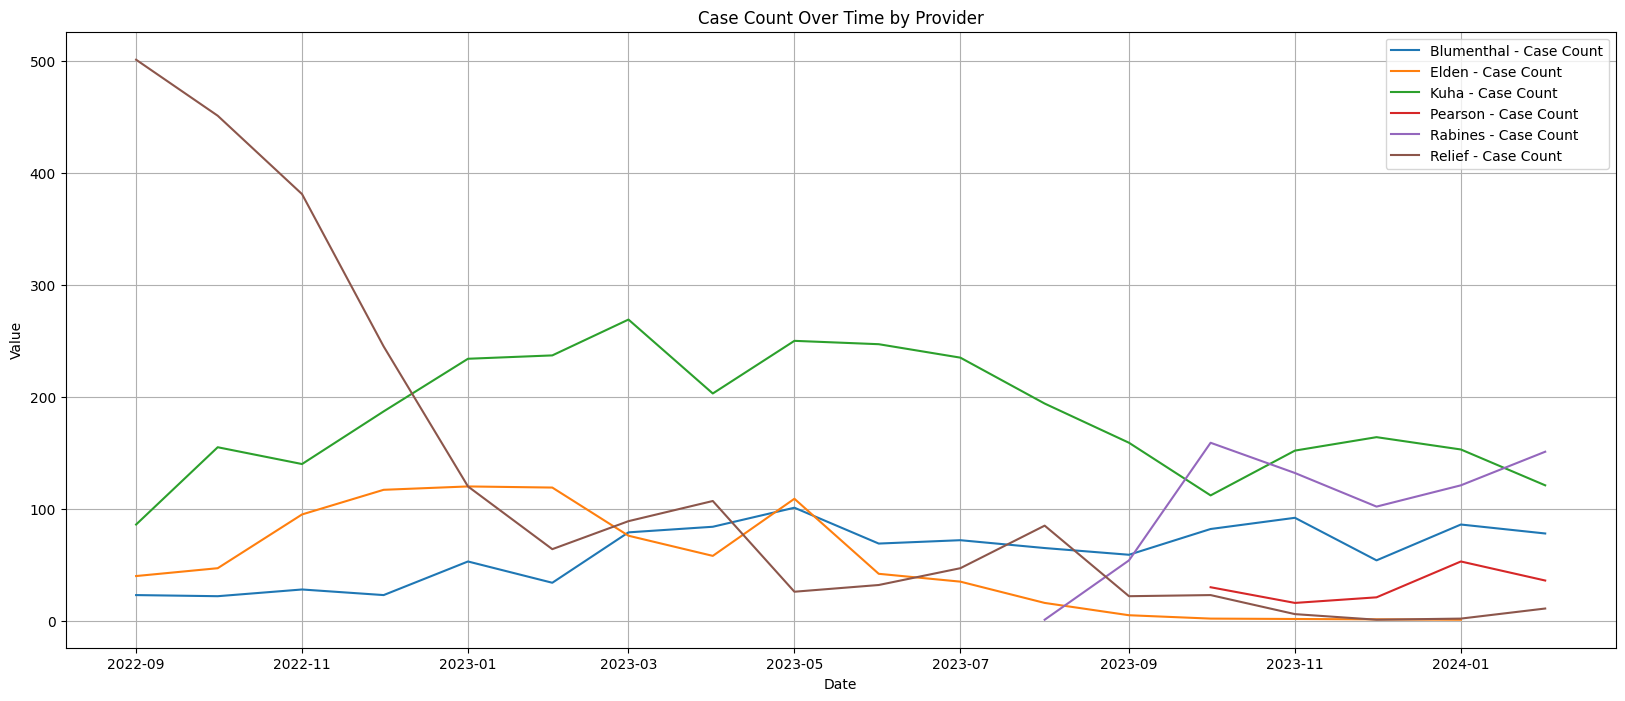

In [171]:
plt.rcParams['figure.figsize'] = [20, 8]

# Group by doctor and date, and compute sums
grouped_df = plt_df.groupby(['doctor', 'date']).sum().reset_index()

for doctor in grouped_df['doctor'].unique():
    df_doctor = grouped_df[grouped_df['doctor'] == doctor]
    plt.plot(df_doctor['date'], df_doctor['case_count'], label=f'{doctor} - Case Count')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Case Count Over Time by Provider')
plt.legend()
plt.grid(True)
plt.show()

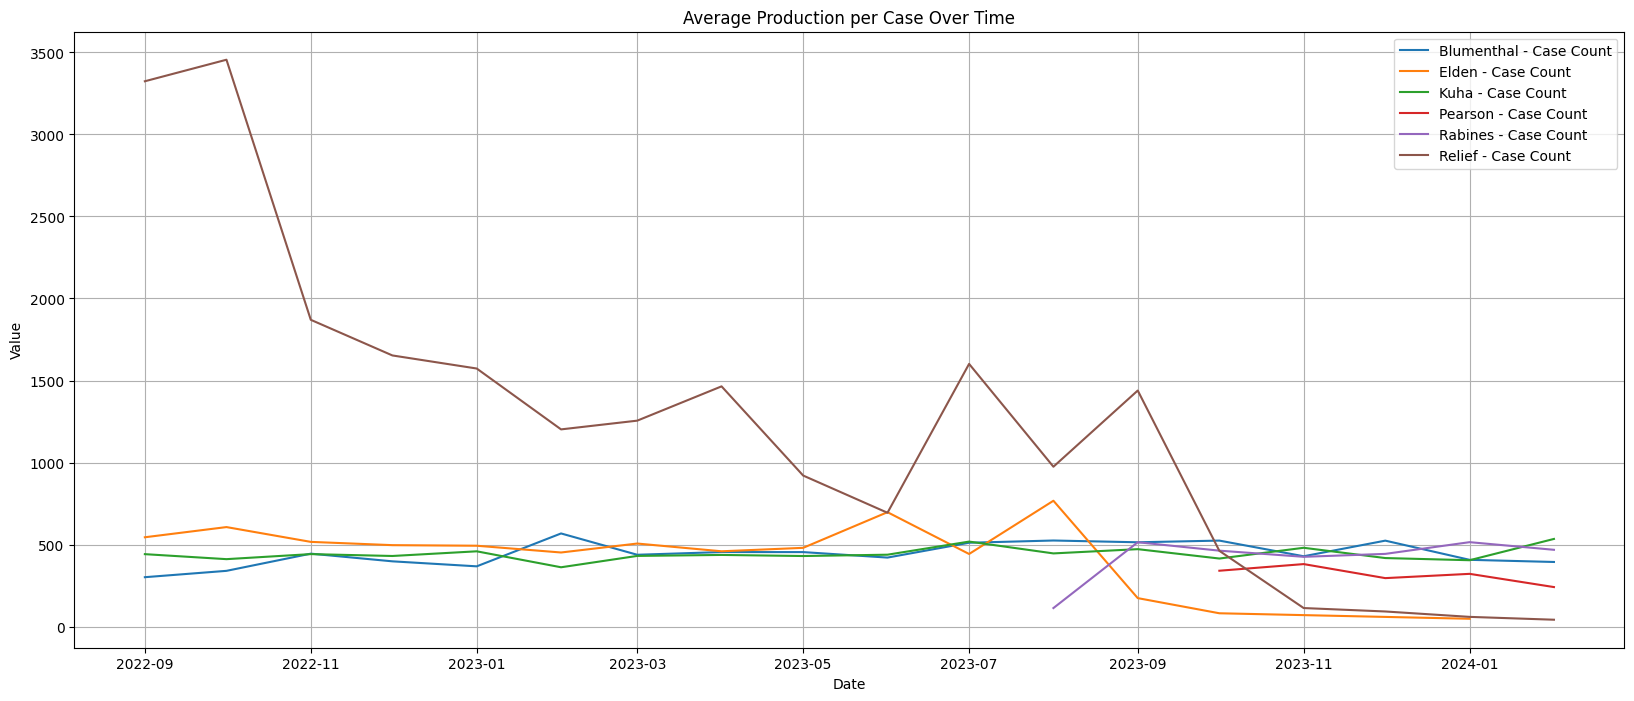

In [169]:
plt.rcParams['figure.figsize'] = [20, 8]

# Group by doctor and date, and compute sums
grouped_df = plt_df.groupby(['doctor', 'date']).sum().reset_index()

for doctor in grouped_df['doctor'].unique():
    df_doctor = grouped_df[grouped_df['doctor'] == doctor]
    plt.plot(df_doctor['date'], df_doctor['average'], label=f'{doctor} - Case Count')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Average Production per Case Over Time')
plt.legend()
plt.grid(True)
plt.show()